First let us import the Basic libraries to load and analyze our dataset

In [103]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Now let's load our dataset and observe it's characteristics

In [105]:
#Load data
df = pd.read_csv("dataset.csv", low_memory=False)
df = df.dropna(subset=['acquirer_response'])
df.head()
print(len(df))
gf = df[df['acquirer_response'] == "FRAUD"]
print(len(gf))

10000
266


Note most columns are irrelevant, let us adjust this to only analyze categorical variables that are relevant and non Metadata.

In [68]:
#Define categorical variables to analyze
group_vars = [
    'payment_method', 'currency', 'issuer_country',
    'shopper_country', 'shopper_interaction', 'issuer_name', 'merchant_account', "liability_shift", "pos_entry_mode", "acquirer", "avs_response", "cvc2_response", "3d_directory_response", "3d_authentication_response", "payment_method_variant", "global_card_brand", "3ds_version"
]

We need an accurate way to determine if these categorical variables meaningfully associate with the likelihood of transaction approval, to measure this, we first define a Cramer V test and utilize it to check against acquirer response.

In [70]:
#Define Base Cramer's V test.
def cramers_v(confusion_matrix):
    if confusion_matrix.size == 0 or confusion_matrix.shape[0] < 2 or confusion_matrix.shape[1] < 2:
        return np.nan

    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    if n == 0:
        return np.nan

    phi2 = chi2 / n
    r, k = confusion_matrix.shape

    with np.errstate(divide='ignore', invalid='ignore'):
        phi2corr = max(0, phi2 - ((k - 1)*(r - 1)) / max(n - 1, 1))
        rcorr = max(r - ((r - 1)**2)/(n - 1), 1)
        kcorr = max(k - ((k - 1)**2)/(n - 1), 1)
        denom = min((kcorr - 1), (rcorr - 1))
        if denom <= 0:
            return np.nan
        return np.sqrt(phi2corr / denom)

Now let us use this test to check each Categorical Variable for correlation with APPROVED status and plot.

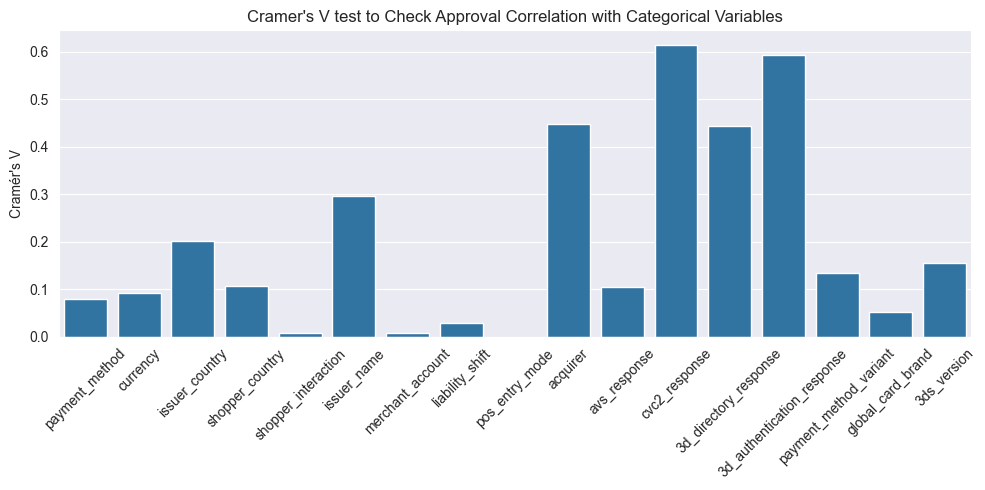

In [71]:
#Create a Column for "APPROVED" showing binary values
df['is_approved'] = df['acquirer_response'] == 'APPROVED'

#Initialize correlations
approval_corrs = {}

#Check correlation for each variable
for col in group_vars:
    cm = pd.crosstab(df[col], df['is_approved'])
    approval_corrs[col] = cramers_v(cm)

#Plot on a Histogram to Display Results
plt.figure(figsize=(10, 5))
sns.barplot(x=list(approval_corrs.keys()), y=list(approval_corrs.values()))
plt.xticks(rotation=45)
plt.ylabel("Cramér's V")
plt.title("Cramer's V test to Check Approval Correlation with Categorical Variables")
plt.tight_layout()
plt.show()


Next, let us draw the Chi-2 Histogram, in this case, we note that Categorical Variables with p > 0.05 are not significantly associated with Approval, these can thus be removed.

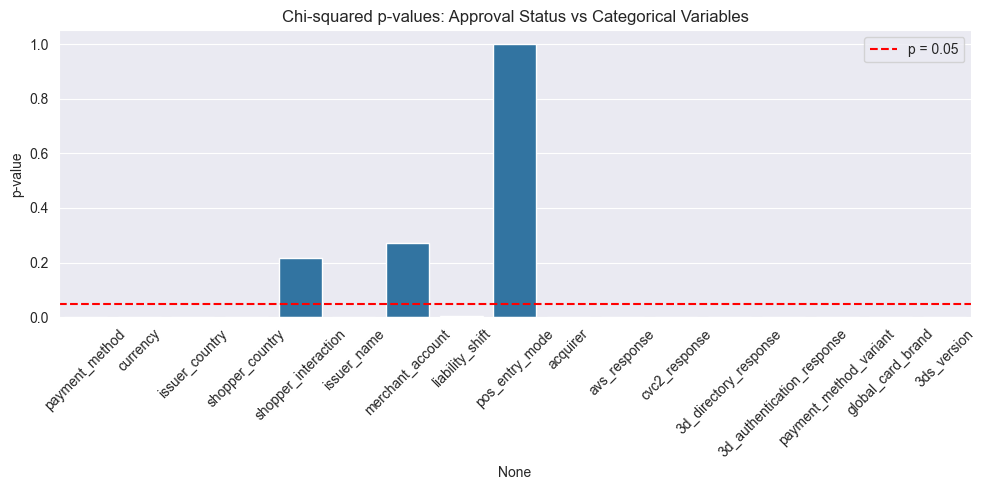

In [73]:
from scipy.stats import chi2_contingency
import seaborn as sns

#Initialize P-values
p_values = {}

#Calculate P-values
for col in group_vars:
    table = pd.crosstab(df[col], df['is_approved'])
    try:
        _, p, _, _ = chi2_contingency(table)
        p_values[col] = p
    except ValueError:
        p_values[col] = None

#Use df to display
results = pd.DataFrame.from_dict(p_values, orient='index', columns=['p_value']).dropna()
results['significant'] = results['p_value'] < 0.05

#Let us plot this
plt.figure(figsize=(10, 5))
sns.barplot(x=results.index, y=results['p_value'])
plt.axhline(0.05, color='red', linestyle='--', label='p = 0.05')
plt.xticks(rotation=45)
plt.title('Chi-squared p-values: Approval Status vs Categorical Variables')
plt.ylabel('p-value')
plt.legend()
plt.tight_layout()
plt.show()


Hence we remove the Categorical Variables that do not associate with the data above.

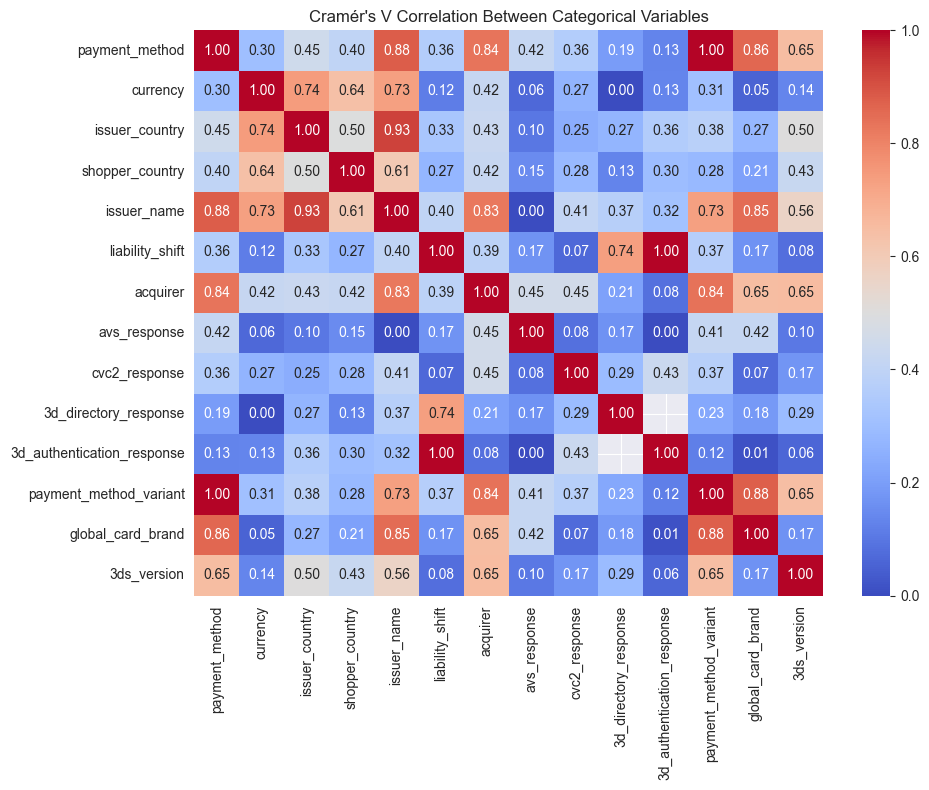

In [76]:
#Refine categorical group variables
group_vars = [
    'payment_method', 'currency', 'issuer_country',
    'shopper_country', 'issuer_name', "liability_shift", "acquirer", "avs_response", "cvc2_response", "3d_directory_response", "3d_authentication_response", "payment_method_variant", "global_card_brand", "3ds_version"
]

#Build new correlation matrix
matrix = pd.DataFrame(index=group_vars, columns=group_vars)

#Calculate Categorical-Categorical correlations with Cramer V test
for col1 in group_vars:
    for col2 in group_vars:
        if col1 == col2:
            matrix.loc[col1, col2] = 1.0
        else:
            cm = pd.crosstab(df[col1], df[col2])
            matrix.loc[col1, col2] = cramers_v(cm)

matrix = matrix.astype(float)

#Let us plot our resutls
plt.figure(figsize=(10, 8))
sns.heatmap(matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Cramér's V Correlation Between Categorical Variables")
plt.tight_layout()
plt.show()


Let us now do a little statistical testing - AKA Machine Learning. We want to check if we can use a basic Random Forests Model to predict Approval. For this, let us first begin by importing the standard Machine Learning libraries. In this case we first start with sci-kit learn which is the standard library utilized when implementing a Random Forest classifier. Random Forests is a tree based method utilized extensively for Tabular Data formats to predict associations: it is an ensemble method which uses multiple "decision trees" to come up with a prediction. Hyperparameters can be utilized to affect this.

In [125]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt


Unlike in the previous time, we again narrow down our categorical variables further, this is because our Machine Learning model needs to be lean, and does not need to necessarily overfit. So we only use 9 categorical variables, and we exclude the technology related categoricals to only utilize what may come from customer inputs - this is so that we can create a model that could later on be transferred for direct usage in systems. Below is our pre-processing.

In [127]:
#Let us Load our Dataset again!
df = pd.read_csv('dataset.csv', low_memory=False)

#Let us now name the variables under which we will apply our classifier, we also include numerical variables that are relevant such as amount, risk scoring and creation_date
group_vars = [
    'issuer_country', 'shopper_country', #'risk_scoring',  
     'amount',
    'creation_date', 'payment_method', 'currency', 'acquirer', 'global_card_brand'
]

#Let us also define the response we check against and load that
df = df.dropna(subset=['acquirer_response'])
df['is_approved'] = (df['acquirer_response'] == 'APPROVED').astype(int)

#Here we try to turn creation_date into minute, drop nulls and adjust into a true numerical
df['creation_date'] = pd.to_datetime(df['creation_date'], errors='coerce')
df = df.dropna(subset=['creation_date']) 
df['minute_of_day'] = df['creation_date'].dt.hour * 60 + df['creation_date'].dt.minute

#Define the Categorical Variables we use
group_vars_processed = [
    'issuer_country', 'shopper_country', #'risk_scoring', 
     'amount',
    'minute_of_day', 'payment_method', 'currency', 'acquirer', 'global_card_brand'
]

#Drop irrelevant parts
df = df.dropna(subset=group_vars_processed)

#Define X and y which is the independent and dependent variables tested
X = df[group_vars_processed]
y = df['is_approved']

#Preprocess to define numerical and categorical features
numeric_features = [#'risk_scoring', 
                    'amount', 
                    'minute_of_day']
categorical_features = list(set(group_vars_processed) - set(numeric_features))

#Define our preprocessor and utilize OneHotEncoding for Categoricals
preprocessor = ColumnTransformer(transformers=[
    ('num', 'passthrough', numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

Now let's actually run our randomforest classifier, let's just use standard number of estimators (100) this is supposed to be a weak model, the point is to see if it works.

In [128]:
#Define the model for training
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

#Create Train test splits use the standard Random State (42) and 20% split for test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#The actual training
model.fit(X_train, y_train)

#Use the training to predict on the test set
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

Let's Graph the ROC curve for the RandomForest classifier for Approval

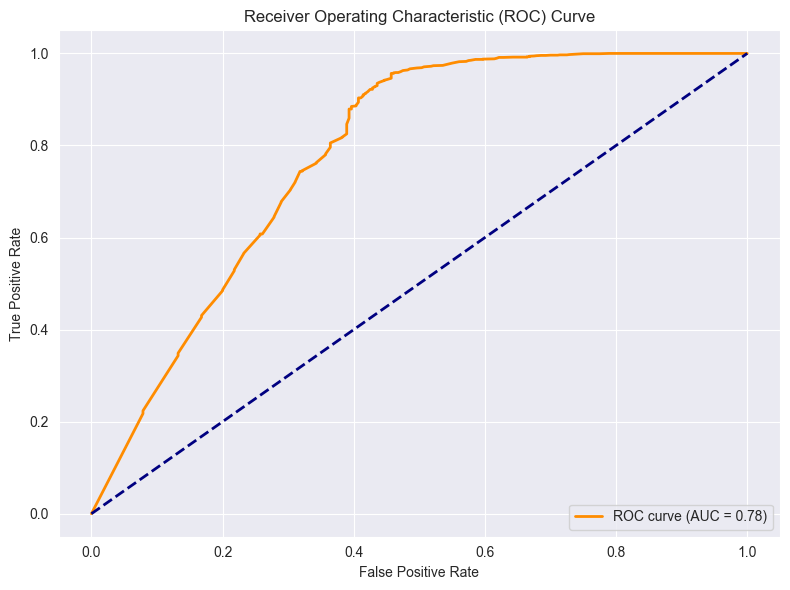

In [129]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


The ROC curve shows a good prediction of the RandomForest classifier for Approval, the below ground truths show the same, this implies this model is very good for the task at hand.

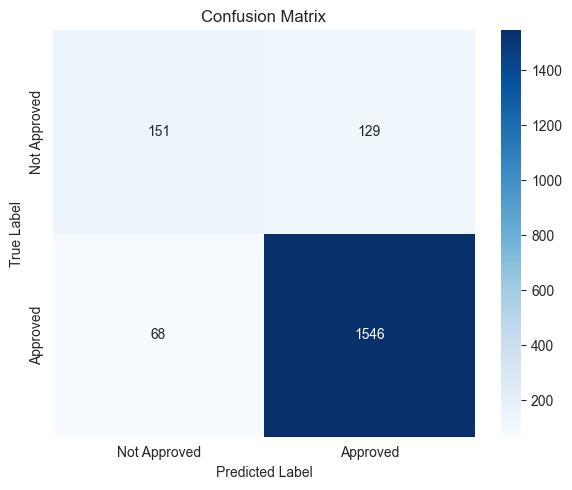

In [130]:
cm = confusion_matrix(y_test, y_pred)
labels = ['Not Approved', 'Approved']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


Now let us use a more refined boosting algorithm - LGB. This is well suited in fraud detection and is used extensively for tabular datasets. Here we change the target we are predicting for to Fraud (though we can easily switch back to the previous one defined above), note how accurate this is.

In [131]:
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier

#Predict for FRAUD
df['FRAUD'] = (df['acquirer_response'] == 'FRAUD').astype(int)
y = df['FRAUD']

#LGBM pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(
        n_estimators=6000,
        learning_rate=0.01,
        max_depth=8,
        class_weight='balanced',
        random_state=42
    ))
])

#Use a 25%, 30% test data instead of 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

#Actual training
model.fit(X_train, y_train)

#Predictions with a 0.5 threshold
y_proba = model.predict_proba(X_test)[:, 1]
threshold = 0.5 
y_pred = (y_proba >= threshold).astype(int)

[LightGBM] [Info] Number of positive: 164, number of negative: 5515
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 676
[LightGBM] [Info] Number of data points in the train set: 5679, number of used features: 85
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

/Users/anirudh/PycharmProjects/pythonProject2/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [132]:
#Evaluation of the model
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"\nROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3685
           1       0.88      0.98      0.93       102

    accuracy                           1.00      3787
   macro avg       0.94      0.99      0.96      3787
weighted avg       1.00      1.00      1.00      3787


ROC AUC Score: 0.9986


Note the ROC curve - 1 = Area under ROC = This is a 100% accurate model for Fraud prediction!

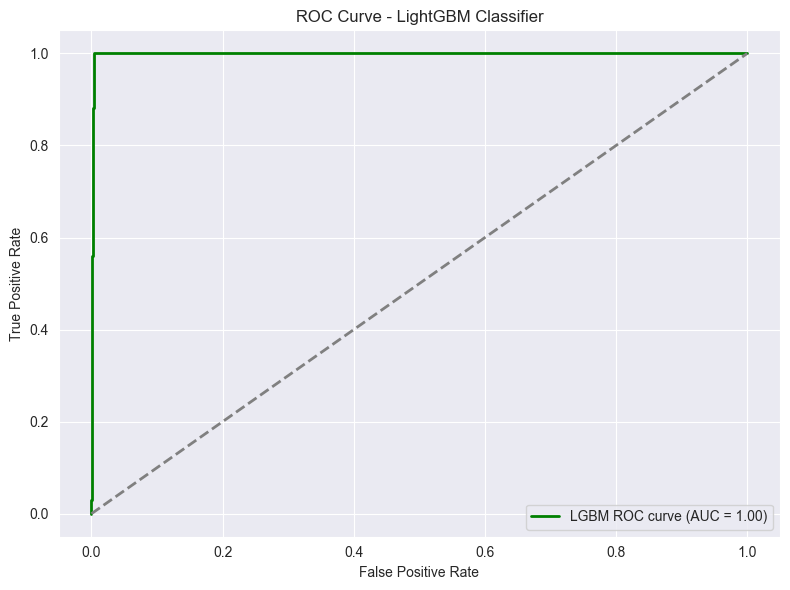

In [133]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='green', lw=2, label=f'LGBM ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LightGBM Classifier')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


Notice the 100% precision, and this is with very little overfitting.

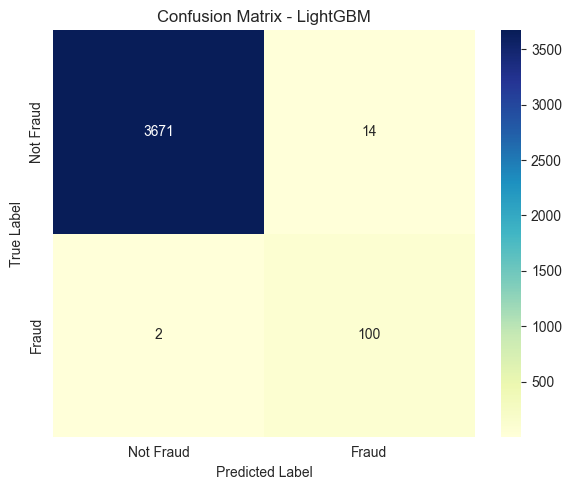

In [134]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
labels = ['Not Fraud', 'Fraud']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - LightGBM')
plt.tight_layout()
plt.show()


In [135]:
#Predictions with a 0.5 threshold
y_proba_total_CSV = model.predict_proba(X)[:, 1]
threshold = 0.5 
df["Fraud_Predicted"] = (y_proba_total_CSV >= threshold).astype(int)
df.head()

/Users/anirudh/PycharmProjects/pythonProject2/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,company_account,merchant_account,psp_reference,merchant_reference,payment_method,creation_date,creation_date_day,creation_date_converted_utc,creation_date_utc_date,timezone,...,card_number,reserved2,reserved3,global_card_brand,row_hash,recurring_detail_reference,is_approved,minute_of_day,FRAUD,Fraud_Predicted
0,Company,CompanyPOS_UK,B9BJWQL428C4M5G6,3f2791d5-fc5a-4e51-a861-cf93030b878c,mc,2024-08-09 01:50:00,1.730000e+12,1.730000e+12,1.730000e+12,CEST,...,NaN,NaN,NaN,Mastercard,deaa6bdd7c990cd63fa8aaede1e3721708f4489151a3bf...,NaN,1,110,0,0
1,Company,CompanyPOS_UK,KZTNS957TKK7H6G6,9b940ba5-202e-4c34-ae10-01be9607ed83,visa,2024-08-09 03:11:00,1.730000e+12,1.730000e+12,1.730000e+12,CEST,...,NaN,NaN,NaN,Visa,4a9b6606ad40b429bad0f251e18f62559e98d33b71cb81...,NaN,1,191,0,0
2,Company,CompanyPOS_UK,PNDNF5Q428C4M5G6,63ededb8-6830-49d2-9021-ebb1364d39f2,mc,2024-08-09 05:04:00,1.730000e+12,1.730000e+12,1.730000e+12,CEST,...,NaN,NaN,NaN,Mastercard,f312141bd0830125cbb99652f41c20b5a3443fb13d3f5e...,NaN,1,304,0,0
3,Company,CompanyPOS_UK,P99R2QKDGC9SG3G6,f8977710-d3e3-4e51-a1a8-ae0f1169d4a0,mc,2024-08-09 05:26:00,1.730000e+12,1.730000e+12,1.730000e+12,CEST,...,NaN,NaN,NaN,Mastercard,a77949d65101c8b60ee53c75d526b310ef5db69903676d...,NaN,1,326,0,0
4,Company,CompanyPOS_UK,BH4DRBWJ5HH2NTF6,fb38eeba-11ea-4b79-8bb7-9a060e97101d,visa,2024-08-09 05:34:00,1.730000e+12,1.730000e+12,1.730000e+12,CEST,...,NaN,NaN,NaN,Visa,d94ad3ab85332c9ebb6ebf6d54b2c3cc8e5bd1a27fd4c8...,NaN,1,334,0,0


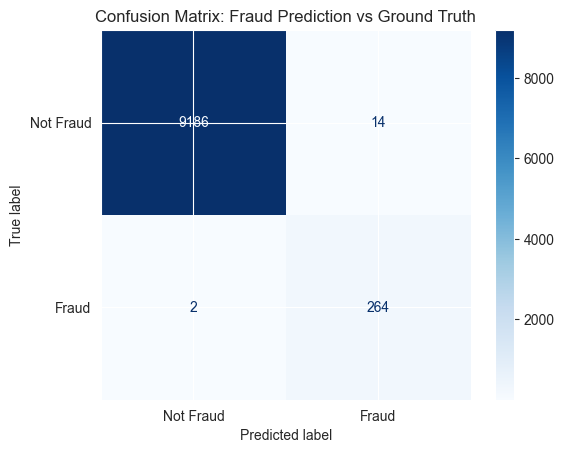

In [136]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

FRAUD_true = (df["acquirer_response"] == "FRAUD").astype(int)
FRAUD_pred = df["Fraud_Predicted"]
cm = confusion_matrix(FRAUD_true, FRAUD_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Fraud", "Fraud"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix: Fraud Prediction vs Ground Truth")
plt.show()


In [101]:
print(len(df))
zf = pd.read_csv('dataset.csv')
print(len(zf))

9466
10000


/var/folders/yh/xflf0j1j37d_363k5l03nr900000gn/T/ipykernel_12753/3200445832.py:2: DtypeWarning: Columns (23,40,81) have mixed types. Specify dtype option on import or set low_memory=False.
  zf = pd.read_csv('dataset.csv')
